## Introduction
This jupyter notebook contains sample code to analyse metadynamic metainference simulations of the 42-residue variant of the monomeric amyloid-β peptide (AB) in the presence and absence of the small molecule, 10074-G5. These simulations were performed using the `GROMACS 2018.3` (1) patched with `PLUMED` library `version 2.6.0-dev` (2), using chemical shifts as restraints to improve force field accuracy. 

Please see our manuscript, 'Small molecule sequestration of amyloid-β as a drug discovery strategy for Alzheimer’s disease' on bioRxiv (https://www.biorxiv.org/content/10.1101/729392v2) for a complete description of how these trajectories were generated. All input files to reproduce these simulations are located in both `../PLUMED_input_files` or PLUMED NEST (`plumID:20.014`, https://www.plumed-nest.org/eggs/20/014/).

## Preprocessing of the trajectories using GROMACS

Partial trajectories for each replica were first concatenated using the GROMACS `gmx trjcat` command to obtain full trajectories per replica. Initially, 10% of each trajectory per replica was discarded for equilibration at this step, but ultimately, we later discard a total of 50% of each simulation for equilibration (see `Load and process metadynamics weights` below).

Time-ordered trajectories from each replica were concatenated together to a single, large trajectory using the `GROMACS gmx trjcat` command. The `PLUMED driver` command was then used to recalcuate the weights on this large trajectory.


The weights of frames in which the peptide interacts with its periodic image have already been set to zero. These frames were identified using the `GROMACS gmx mindist` command. The cut-off for self-interaction was set to 1.2 nm.

No frames with from the holo trajectories were found to have any self interactions. From the apo trajectories, less than 0.001% of the ensemble (by metadynamics weight) were removed.

## References

(1) M.J. Abraham, T. Murtola, R. Schulz, S. Páll, J.C. Smith, B. Hess, and E. Lindahl, GROMACS: High performance molecular simulations through multi-level parallelism from laptops to supercomputers, SoftwareX, 1–2 19–25 (2015).

(2) The PLUMED consortium, Promoting transparency and reproducibility in enhanced molecular simulations. Nat. Methods 16, 670-673 (2019).


## Set up notebook

Please note that this notebook requires large data files which can be downloaded from Zenodo here: 

In [1]:
#Import useful tools
import mdtraj as md
import numpy as np
import mdtraj as md
import matplotlib.colors as clr
import pandas as pd
from glob import glob
from itertools import *
import math
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

In [2]:
#Define function to return the weighted average and standard deviation
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [3]:
#Define some presets for plotting
plt.rcParams['font.serif'] = "Arial"
plt.rcParams['font.family'] = "serif"
plt.rcParams.update({'font.size': 12})

#Define colors 
c_AB = (0.7686, 0.4196, 0.1882, 1)   #set color for AB points
e_AB = (0.7686, 0.4196, 0.1882, 0.5) #set color for AB errors
c_G5 = (0.3725, 0.5804, 0.4588, 1)   #set color for AB+10074-G5 points
e_G5 = (0.3725, 0.5804, 0.4588, 0.5) #set color for AB+10074-G5 errors
blue_dark  = (0.4392, 0.5961, 0.8196) #set dark blue
blue_light = (0.6549, 0.7765, 0.8941) #set light blue
red_dark   = (0.4431, 0.1059, 0.0941) #set dark red
red_light  = (0.6392, 0.4118, 0.3882) #set light red

#Define a colormaps
cmap_AB_con  = clr.LinearSegmentedColormap.from_list('name', [c_AB, 'w', 'grey'], N=256, gamma=1.0)
cmap_G5_con  = clr.LinearSegmentedColormap.from_list('name', [c_G5, 'w', 'grey'], N=256, gamma=1.0)
cmap_AB_ring = clr.LinearSegmentedColormap.from_list('name', [c_AB, 'w'], N=100, gamma=1.0)
cmap_G5_ring = clr.LinearSegmentedColormap.from_list('name', [c_G5, 'w'], N=100, gamma=1.0)

#Define AB42 sequence 
ab_seq = 'DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA'
#Define AB42 sequence in absence of terminal residues
ab_seq_no_ter = 'AEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVI'

## Load trajectories 

In [4]:
#Load trajectory and topology for AB alone
tAB = md.load('Zenodo/traj_all-skip-0-noW_AB.xtc', top='Zenodo/template_AB.pdb')
#Check details about trajectory
print(tAB)

<mdtraj.Trajectory with 252816 frames, 627 atoms, 42 residues, and unitcells>


In [5]:
#Load trajectory and topology for AB + 10074-G5
tG5 = md.load('Zenodo/traj_all-skip-0-noW_G5.xtc', top='Zenodo/template_G5.pdb')
#Check details about trajectory
print(tG5)

<mdtraj.Trajectory with 256128 frames, 664 atoms, 43 residues, and unitcells>


## Load and process metadynamics weights  

In [6]:
#Load in metadynamics weights for AB alone
wAB = np.loadtxt('Zenodo/weights_corr_AB')

#Load in metadynamics weights for AB + 10074-G5
wG5 = np.loadtxt('Zenodo/weights_corr_G5')

#Normalise metadynamis weights
wAB /= wAB.sum() 
wG5 /= wG5.sum() 

For the AB + 10074-G5, we sometimes we want to consider 'bound' frames, in which 10074-G5 is in close contact with AB. 
Using PLUMED, distance between 10074-G5 and each residue was computed using the `DISTANCE` directive in `PLUMED`.

In [7]:
#Load in output from distance-per-residue output (descibed above) from PLUMED
dists = np.loadtxt('Zenodo/COLVAR_dists')

#Create a list called 'cons' indicating in which frames 10074-G5 is less than 0.8 nm from any residue
cons = (dists < 0.8).any(axis=1)
        
#Set the weights of all 'dissociated' states to zero
wG5_bound = cons*wG5

#Make list of dissociated states and get their weights
wG5_unbound = wG5[~cons].copy()

#Print some information
print('Bound weights make up', 100*wG5_bound.sum(),'% of total holo ensemble')

#Renormalise the bound metadynamis weights
wG5_bound /= wG5_bound.sum() 
wG5_unbound /= wG5_unbound.sum() 

Bound weights make up 99.07762601253448 % of total holo ensemble


To allow for a generous equilibration time, the first half of the simulations were discarded. 10% of the simulations have already been discarded in pre-processing using `GROMACS` (see `Preprocessing of the trajectories using GROMACS` above). Thus, for simplicity, we will set the weights of all remaining frames in the first halves of the simulations to zero. 

In [8]:
#Given that the simulations is arranged as 48 time-ordered replicas, we split up the weights into 48 separate arrays
n_reps = 48 #set number of replicas

#For AB alone:
wAB_split = np.split(wAB, n_reps)

#For AB +10074-G5:
wG5_split = np.split(wG5, n_reps)

#For AB +10074-G5 (bound only):
wG5_bound_split = np.split(wG5_bound, n_reps)

#Now we must determine how many frames from each replica to discard:

#First, determine original length of each replica, before 10% was removed
origAB=(len(wAB)/n_reps)+(len(wAB)/n_reps)*0.1
origG5=(len(wG5)/n_reps)+(len(wG5)/n_reps)*0.1

#Now, we divide this value by 2 to determine how many frames to keep at the end of each replica
keep_AB = np.floor((origAB)/2)
keep_G5 = np.floor((origG5)/2)

#Set first values in AB ensemble to zero 
for i in range(0, n_reps):
    wAB_split[i][0:(len(wAB)/n_reps-keep_AB).astype(int)] = 0
    wG5_split[i][0:(len(wG5)/n_reps-keep_G5).astype(int)] = 0
    wG5_bound_split[i][0:(len(wG5)/n_reps-keep_G5).astype(int)] = 0

#Concatenate the separate arrays again
wAB_eq = np.hstack(wAB_split)
wG5_eq = np.hstack(wG5_split)
wG5_bound_eq = np.hstack(wG5_bound_split)

#Renormalise metadynamis weights
wAB_eq /= wAB_eq.sum()
wG5_eq /= wG5_eq.sum()
wG5_bound_eq /= wG5_bound_eq.sum()      

## Selecting a random subsample of the trajectories for more efficient processing 
Sometimes, it is easier to perform calculations on a subset of the trajectory. To account for the metadynamics weights, we select these frames in a weighted manner. To determine the maximum size of this subsampled trajectories, we will calculate the Kish effective sample sizes, based on the metadynamics weights. 

In [9]:
#Now get kish for each of the trajectories weights
kish_AB = ((wAB_eq.sum())*(wAB_eq.sum()))/((wAB_eq*wAB_eq).sum())
kish_G5 = ((wG5_eq.sum())*(wG5_eq.sum()))/((wG5_eq*wG5_eq).sum())
kish_G5_bound = ((wG5_bound_eq.sum())*(wG5_bound_eq.sum()))/((wG5_bound_eq*wG5_bound_eq).sum())
print('Kish for AB alone is', kish_AB)
print('Kish for AB with 10075-G5 is', kish_G5)
print('Kish for AB with 10075-G5 (bound only) is', kish_G5_bound)

Kish for AB alone is 51928.92862795881
Kish for AB with 10075-G5 is 39236.957984336776
Kish for AB with 10075-G5 (bound only) is 38850.534849865406


Based on the numbers above, we chose to select 35,000 frames. We randomly select these frames in a weighted way. To repeat this random selection yourself, uncomment out the relevant lines below. Note that results may vary.

In [10]:
#FOR AB alone:
#top_framesAB = np.random.choice(wAB_eq.shape[0], 35000, p = wAB_eq, replace=False) #select frames from the trajectory. do not use duplicates
#top_framesAB.sort(axis = 0) #sort the array in place
#np.save('top_framesAB_new', top_framesAB) #save the chosen frames

#load in the the top frames used in this analysis
#if above uncommented, comment out the line below.
top_framesAB = np.load('Zenodo/top_framesAB.npy')

#FOR AB + 10074-G5 (note we only select from bound frames)
#top_framesG5 = np.random.choice(wG5_bound_eq.shape[0], 35000, p = wG5_bound_eq, replace=False) #select frames from the trajectory. do not use duplicates
#top_framesG5.sort(axis = 0) #sort the array in place
#np.save('top_framesG5_new', top_framesG5) #save the chosen frames

#load in the the top frames used in this analysis
#if above uncommented, comment out the line below.
top_framesG5 = np.load('Zenodo/top_framesG5.npy')

## Consistency of the simulation with chemical shift data
Chemical shift data was used to restrain the apo and holo simulations to improve force field accuracy. Given that the error of the CamShift predictor is greater than the chemical shift perturbations upon addition of the compound (1), the same chemical shifts were used to restrain both the unbound and bound simulations.

Chemical shifts were back-calculated at each time step using `CamShift` (3) within `PLUMED` using the `CS2BACKBONE` directive.

## Reference
(3) P. Robustelli, K. Kohlhoff, A. Cavalli, M. Vendruscolo, Using NMR chemical shifts as structural restraints in molecular dynamics simulations of proteins. Structure 18, 923-933 (2010).

In [11]:
#Load in CAMSHIFT output from PLUMED using pandas 
#For AB alone:
csAB = pd.read_csv('Zenodo/CS_COLVAR_AB', delim_whitespace=True)

#For AB + 10074-G5:
csG5 = pd.read_csv('Zenodo/CS_COLVAR_G5', delim_whitespace=True)

#Load in data (same for AB alone and AB + 10074-G5)
ref = pd.read_csv('Zenodo/CS_COLVAR_AB', delim_whitespace=True, nrows=4)

In [12]:
#Make dictionaries of different chemical shift types
#For AB alone:
csAB_dict = {'ca': np.asarray(csAB.loc[:, 'cs.ca-0-2':'cs.ca-0-41']), 'cb': np.asarray(csAB.loc[:, 'cs.cb-0-2':'cs.cb-0-40']),
             'co': np.asarray(csAB.loc[:, 'cs.co-0-2':'cs.co-0-41']), 'ha': np.asarray(csAB.loc[:, 'cs.ha-0-2':'cs.ha-0-41']),
             'hn': np.asarray(csAB.loc[:, 'cs.hn-0-2':'cs.hn-0-41']), 'nh': np.asarray(csAB.loc[:, 'cs.nh-0-2':'cs.nh-0-41'])}

#For AB + 10074-G5:
csG5_dict = {'ca': np.asarray(csG5.loc[:, 'cs.ca-0-2':'cs.ca-0-41']), 'cb': np.asarray(csG5.loc[:, 'cs.cb-0-2':'cs.cb-0-40']),
             'co': np.asarray(csG5.loc[:, 'cs.co-0-2':'cs.co-0-41']), 'ha': np.asarray(csG5.loc[:, 'cs.ha-0-2':'cs.ha-0-41']),
             'hn': np.asarray(csG5.loc[:, 'cs.hn-0-2':'cs.hn-0-41']), 'nh': np.asarray(csG5.loc[:, 'cs.nh-0-2':'cs.nh-0-41'])}

#For data (shared between both sets of simulations)
data_dict = {'ca': np.asarray(csG5.loc[:, 'cs.expca-0-2':'cs.expca-0-41']), 'cb': np.asarray(csG5.loc[:, 'cs.expcb-0-2':'cs.expcb-0-40']),
             'co': np.asarray(csG5.loc[:, 'cs.expco-0-2':'cs.expco-0-41']), 'ha': np.asarray(csG5.loc[:, 'cs.expha-0-2':'cs.expha-0-41']),
             'hn': np.asarray(csG5.loc[:, 'cs.exphn-0-2':'cs.exphn-0-41']), 'nh': np.asarray(csG5.loc[:, 'cs.expnh-0-2':'cs.expnh-0-41'])}

cs_residues = {'ca': [2,3,4,5,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41],
               'cb': [2,3,4,5,7,8,10,11,12,16,17,18,19,20,21,22,23,24,26,27,28,30,34,35,36,39,40],
               'co': [2,3,4,5,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41],
               'ha': [2,3,4,5,7,8,10,11,12,15,16,17,18,19,20,21,22,23,24,26,27,28,30,31,32,34,35,36,39,40,41],
               'hn': [2,3,4,5,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41],
               'nh': [2,3,4,5,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]}

Calculate means and standard deviations between the chemical shifts from the first and second halves of the AB trajectories

In [13]:
#Define start and end points to determine first and second halves of trajectories per replica 
start_AB = (len(wAB_eq)/n_reps-keep_AB).astype(int)
end_AB = int((len(wAB_eq)/48))
mid_AB = (start_AB + (end_AB-start_AB)/2).astype(int)

#Reshape weights array to account for individual replicas
wAB_reps = np.reshape(wAB_eq.copy(), (n_reps, np.int(len(wAB_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
wAB_0 = wAB_reps.copy()[:, start_AB:mid_AB]
wAB_1 = wAB_reps.copy()[:, mid_AB:end_AB]

#Use this to determine effective weight of first and second halves of the trajectory
sum_wAB_0 = wAB_0.sum()
sum_wAB_1 = wAB_1.sum()

#Normalise weights of first and second halves of the trajectory 
wAB_0 /= wAB_0.sum()      
wAB_1 /= wAB_1.sum() 

#Define empty dictionaries (see below)
CS_AB_reps = {} 
csAB_means = {}
csAB_means_0 = {}
csAB_means_1 = {}
csAB_std = {}
for k in cs_residues.keys():
    #Reshape chemical shift arrays to account for individual replicas
    CS_AB_reps[k] = np.reshape(csAB_dict[k], (n_reps, np.int(len(wAB_eq)/n_reps), -1))
    #Make dictionary containing means calculated over whole trajectory
    csAB_means[k] = (wAB_reps*CS_AB_reps[k]).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over first half of trajectory
    csAB_means_0[k] = (CS_AB_reps[k][:, start_AB:mid_AB]*wAB_0).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over second half of trajectory
    csAB_means_1[k] = (CS_AB_reps[k][:, mid_AB:end_AB]*wAB_1).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing standard deviations calculated between first and second halves
    csAB_std[k] = [weighted_avg_and_std([csAB_means_0[k][i], csAB_means_1[k][i]], [sum_wAB_0, sum_wAB_1])[1] for i in range(0, csAB_means_0[k].shape[0])]

Calculate means and standard deviations between the chemical shifts from the first and second halves of the AB + 10074-G5 trajectories

In [14]:
#Define start and end points to determine first and second halves of trajectories per replica 
start_G5 = (len(wG5_bound_eq)/n_reps-keep_G5).astype(int)
end_G5 = int((len(wG5_bound_eq)/n_reps))
mid_G5 = (start_G5 + (end_G5-start_G5)/2).astype(int)

#Reshape weights array to account for individual replicas
wG5_reps = np.reshape(wG5_bound_eq.copy(), (n_reps, np.int(len(wG5_bound_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
wG5_0 = wG5_reps.copy()[:, start_G5:mid_G5]
wG5_1 = wG5_reps.copy()[:, mid_G5:end_G5]

#Use this to determine effective weight of first and second halves of the trajectory
sum_wG5_0 = wG5_0.sum()
sum_wG5_1 = wG5_1.sum()

#Normalise weights of first and second halves of the trajectory 
wG5_0 /= wG5_0.sum()      
wG5_1 /= wG5_1.sum() 

#Define empty dictionaries (see below)
CS_G5_reps = {} 
csG5_means = {}
csG5_means_0 = {}
csG5_means_1 = {}
csG5_std = {}

for k in cs_residues.keys():
    #Reshape chemical shift arrays to account for individual replicas
    CS_G5_reps[k] = np.reshape(csG5_dict[k], (n_reps, np.int(len(wG5_bound_eq)/n_reps), -1))
    #Make dictionary containing means calculated over whole trajectory
    csG5_means[k] = (wG5_reps*CS_G5_reps[k]).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over first half of trajectory
    csG5_means_0[k] = (CS_G5_reps[k][:, start_G5:mid_G5]*wG5_0).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over second half of trajectory
    csG5_means_1[k] = (CS_G5_reps[k][:, mid_G5:end_G5]*wG5_1).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing standard deviations calculated between first and second halves
    csG5_std[k] = [weighted_avg_and_std([csG5_means_0[k][i], csG5_means_1[k][i]], [sum_wG5_0,sum_wG5_1])[1] for i in range(0, csG5_means_0[k].shape[0])]    

Plot predicted chemical shifts for apo (orange) and holo (green) simulations, errorbars represent standard deviations between first and second halves. Grey points are experimental values, errorbars represent error of the predictor reported in reference (3)


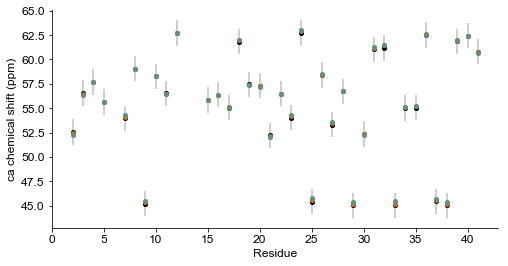

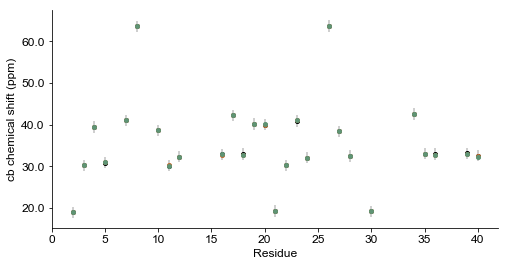

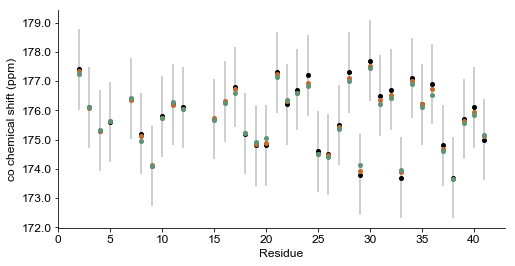

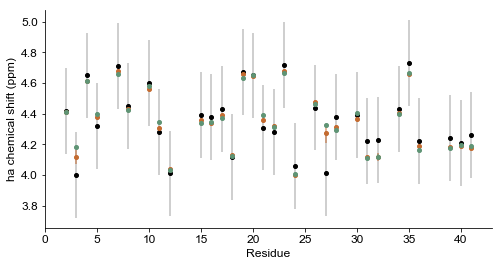

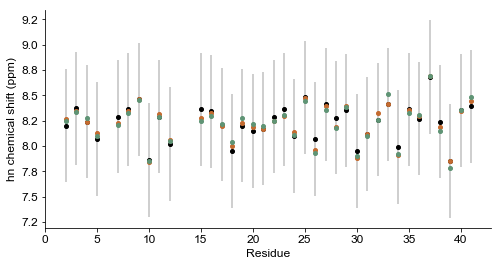

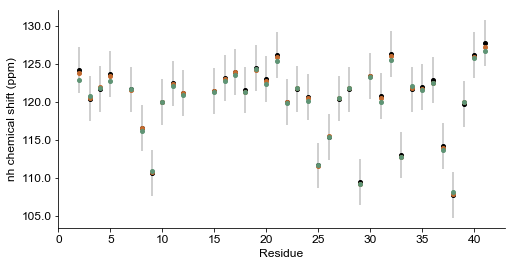

In [15]:
#Plot camshift 
camshift_errs = {'ca': 1.3, 'cb': 1.36, 'co': 1.38, 'ha': 0.28, 'hn': 0.56, 'nh': 3.01}

for k in cs_residues.keys():
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.errorbar(cs_residues[k], data_dict[k].mean(axis=0), yerr=np.full(len(cs_residues[k]), camshift_errs[k]), fmt='o', markersize='4', color='black', ecolor='silver')
    ax.errorbar(cs_residues[k], csAB_means[k], yerr=csAB_std[k], fmt='o', markersize='4', ecolor=e_AB, elinewidth=2, color=c_AB)
    ax.errorbar(cs_residues[k], csG5_means[k], yerr=csG5_std[k], fmt='o', markersize='4', ecolor=e_G5, elinewidth=2, color=c_G5)
    ax.set_xlabel("Residue")
    ax.set_ylabel("{} chemical shift (ppm)".format(k))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xticks(np.arange(0, 42, step=5));
    #plt.savefig('{}_CS.pdf'.format(i), format='pdf', dpi=2000, transparent=True)

## Analysis of inter-residue contacts

Next, we want to examine whether there are differences in inter-residue contacts between AB in the presence and absence of 10074-G5. This analysis is based on Lennard Jones (LJ) and Coulomb (Coul) interaction energies between residues (and residues and 10074-G5) calculated using the `GROMACS gmx energy` tool. Only short-range interaction energies were considered within a 1.2 nm cut-off. LJ contacts will also be used as input for the `GROMOS` (4) clustering analysis.

## Reference
(4) X. Daura et al., Peptide folding: when simulation meets experiment. Angew. Chem. Int. 38, 236-240 (1999).

In [16]:
#Load in data from GROMACS 'gmx energy'
#For AB alone:
Coul_AB = np.loadtxt('Zenodo/inter_residue_contacts_AB_alone_Coul_SR.xvg', comments=('#', '@'))
LJ_AB   = np.loadtxt('Zenodo/inter_residue_contacts_AB_alone_LJ_SR.xvg', comments=('#', '@'))

#For AB + 10074-G5: 

Coul_G5 = np.loadtxt('Zenodo/inter_residue_contacts_AB_with_10074_G5_Coul_SR.xvg', comments=('#', '@'))
LJ_G5   = np.loadtxt('Zenodo/inter_residue_contacts_AB_with_10074_G5_LJ_SR.xvg', comments=('#', '@'))

In [17]:
#Triangulate the LJ for AB alone for each frame:
tri_LJ_AB = np.empty((len(LJ_AB), 42, 42))
for i in range(0, len(LJ_AB)):
    data = LJ_AB[i, 1:904]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_LJ_AB[i] = out
    
#Save matrix    
#np.save('LJ_AB_matrix', tri_LJ_AB) #commented out as file is very large

#Account for weights
tri_LJ_AB_w = tri_LJ_AB * np.reshape(wAB_eq.copy(), ((len(wAB_eq)), 1, 1)) 

#Triangulate the Coul for AB alone for each frame:
tri_Coul_AB = np.empty((len(Coul_AB), 42, 42))
for i in range(0, len(Coul_AB)):
    data = Coul_AB[i, 1:904]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_Coul_AB[i] = out

#Save matrix    
#np.save('Coul_AB_matrix', tri_Coul_AB) #commented out as file is very large

#Account for weights
tri_Coul_AB_w = tri_Coul_AB * np.reshape(wAB_eq.copy(), ((len(wAB_eq)), 1, 1)) 

In [18]:
#Triangulate the LJ for AB +10074-G5 for each frame:
tri_LJ_G5= np.empty((len(LJ_G5), 42, 42))
for i in range(0, len(LJ_G5)):
    data = LJ_G5[i, 1:904]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_LJ_G5[i] = out

#Save matrix    
#np.save('LJ_G5_matrix', tri_LJ_G5) #commented out as file is very large

#Account for weights
tri_LJ_G5_w = tri_LJ_G5[:,:-1,:-1] * np.reshape(wG5_bound_eq.copy(), ((len(wG5_bound_eq)), 1, 1)) 

#Triangulate the Coul for AB + 10074-G5 for each frame:
tri_Coul_G5 = np.empty((len(Coul_G5), 42, 42))
for i in range(0, len(Coul_G5)):
    data = Coul_G5[i, 1:904]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_Coul_G5[i] = out

#Save matrix    
#np.save('Coul_G5_matrix', tri_Coul_G5) #commented out as file is very large

#Account for weights
tri_Coul_G5_w = tri_Coul_G5[:,:-1,:-1] * np.reshape(wG5_bound_eq.copy(), ((len(wG5_bound_eq)), 1, 1)) 

In [19]:
#Make versions of of LJ_AB, LJ_G5, Coul_AB, and Coul_G5 based on top frames
LJ_AB_cut = LJ_AB[top_framesAB][:, 1:904]
LJ_G5_cut = LJ_G5[top_framesG5][:, 1:904]

Coul_AB_cut = Coul_AB[top_framesAB][:, 1:904]
Coul_G5_cut = Coul_G5[top_framesG5][:, 1:904]

To convert these interaction energies into a contact map, interactions which were less than one standard deviation from the mean were assigned a value of -1, those within one standard deviation of the mean were assigned a value of 0, and those greater than one standard deviation of the mean were assigned a value of 1.

In [20]:
#Convert LJ_AB_cut into 1, 0, -1
mean = LJ_AB_cut.mean()
std  = LJ_AB_cut.std()
LJ_AB_cut_ones = np.zeros_like(LJ_AB_cut)
LJ_AB_cut_ones[LJ_AB_cut > (mean + std)] = 1
LJ_AB_cut_ones[LJ_AB_cut < (mean - std)] = -1

#Triangulate array for LJ_AB:
tri_LJ_AB_cut_ones = np.empty((len(LJ_AB_cut), 42, 42))
for i in range(0, len(LJ_AB_cut_ones)):
    data = LJ_AB_cut_ones[i]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_LJ_AB_cut_ones[i] = out
            
#Convert LJ_G5_cut into 1, 0, -1
mean = LJ_G5_cut.mean()
std  = LJ_G5_cut.std()
LJ_G5_cut_ones = np.zeros_like(LJ_G5_cut)
LJ_G5_cut_ones[LJ_G5_cut > (mean + std)] = 1
LJ_G5_cut_ones[LJ_G5_cut < (mean - std)] = -1
            
#Triangulate array for LJ_G5:
tri_LJ_G5_cut_ones = np.empty((len(LJ_G5_cut), 42, 42))
for i in range(0, len(LJ_G5_cut_ones)):
    data = LJ_G5_cut_ones[i]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_LJ_G5_cut_ones[i] = out
    
#Convert Coul_AB_cut into 1, 0, -1
mean = Coul_AB_cut.mean()
std  = Coul_AB_cut.std()
Coul_AB_cut_ones = np.zeros_like(Coul_AB_cut)
Coul_AB_cut_ones[Coul_AB_cut > (mean + std)] = 1
Coul_AB_cut_ones[Coul_AB_cut < (mean - std)] = -1
            
#Triangulate array for Coul_AB:
tri_Coul_AB_cut_ones = np.empty((len(Coul_AB_cut), 42, 42))
for i in range(0, len(Coul_AB_cut_ones)):
    data = Coul_AB_cut_ones[i]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_Coul_AB_cut_ones[i] = out
    
#Convert Coul_G5_cut into 1, 0, -1
mean = Coul_G5_cut.mean()
std  = Coul_G5_cut.std()
Coul_G5_cut_ones = np.zeros_like(Coul_G5_cut)
Coul_G5_cut_ones[Coul_G5_cut > (mean + std)] = 1
Coul_G5_cut_ones[Coul_G5_cut < (mean - std)] = -1
            
#Triangulate array for Coul_G5:
tri_Coul_G5_cut_ones = np.empty((len(Coul_G5_cut), 42, 42))
for i in range(0, len(Coul_G5_cut_ones)):
    data = Coul_G5_cut_ones[i]
    out = np.zeros((42, 42))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_Coul_G5_cut_ones[i] = out

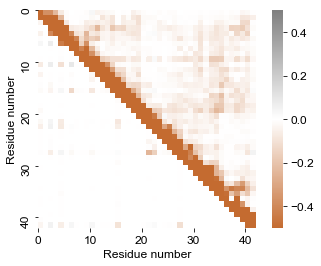

In [21]:
#Plot AB alone contacts based on LJ and Coul contacts
#Note the residues in the plot are indexed from zero
#The code below puts the Coul contacts into the bottom left half of the plot
invert_AB = tri_Coul_AB_cut_ones.mean(axis=0)
tri_Coul_AB_cut_ones_bottom = invert_AB.T

#Combine both LJ and Coul into a single plot           
combo_AB = tri_LJ_AB_cut_ones.mean(axis=0)+tri_Coul_AB_cut_ones_bottom
np.fill_diagonal(combo_AB, -1)
ax = sns.heatmap(combo_AB, vmin=-0.5, vmax=0.5, cmap=cmap_AB_con, center=0, cbar=True, square=True)

ax.set_xticks(np.arange(0, 41, 10)) 
ax.set_yticks(np.arange(0, 41, 10)) 
ax.set_xticklabels((0, 10, 20, 30, 40), rotation='horizontal')
ax.set_yticklabels((0, 10, 20, 30, 40))
ax.set_xlabel("Residue number")
ax.set_ylabel("Residue number");
#plt.savefig('AB_LJ_Coul_ones.eps', format='eps', dpi=1000, transparent=True)

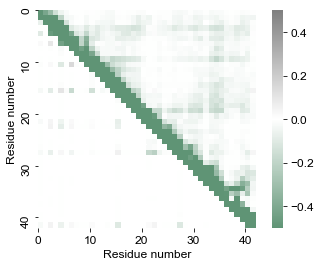

In [22]:
#Plot AB + 10074-G5 contacts based on LJ and Coul contacts
#Note the residues in the plot are indexed from zero
#The code below puts the Coul contacts into the bottom left half of the plot
invert_G5 = tri_Coul_G5_cut_ones.mean(axis=0) 
tri_Coul_G5_cut_ones_bottom = invert_G5.T

#Combine both LJ and Coul into a single plot 
combo_G5 = tri_LJ_G5_cut_ones.mean(axis=0)+tri_Coul_G5_cut_ones_bottom

np.fill_diagonal(combo_G5, -1)
ax = sns.heatmap(combo_G5, vmin=-0.5, vmax=0.5, cmap=cmap_G5_con, center=0, cbar=True, square=True)

ax.set_xticks(np.arange(0, 41, 10)) 
ax.set_yticks(np.arange(0, 41, 10)) 
ax.set_xticklabels((0, 10, 20, 30, 40), rotation='horizontal')
ax.set_yticklabels((0, 10, 20, 30, 40))
ax.set_xlabel("Residue number")
ax.set_ylabel("Residue number");
#plt.savefig('G5_LJ_Coul_ones.eps', format='eps', dpi=1000, transparent=True)

## GROMOS clustering analysis
Using the LJ matrices from the top_frames obtained above, we can prepare input for `GROMOS` (4) clustering. 

In [23]:
#Concatenate subset of LJ frames for AB alone and AB + 10074-G5     
LJall_AB_G5_cut = np.concatenate((LJ_AB_cut, LJ_G5_cut))

#Pair each frame with its index using enumerate. Shuffle, and save indices/
#To repeat this random shuffle yourself, uncomment out the relevant lines below. Note that results may vary.

#l = LJall_AB_G5_cut
#x = list(enumerate(l))
#np.random.shuffle(x)
#indices, l=zip(*x)
#np.save('LJ_shuffled_AB_G5', l)
#np.save('indices', indices)

#Load indices 
indices = np.load('gromos_clustering/indices.npy')
#LJ_shuffled_AB_G5 = no.load('gromos_clustering/LJ_shuffled_AB_G5') #not included due to file size.

The GROMOS clustering analysis is performed in two steps: matrix calculation and GROMOS clustering. As this is a memory-intensive calculation, it was performed on our local cluster. First, we calculate a matrix which containg the root-mean-square deviation (RMSD) between each frame and every other frame using `/gromos_clustering/matrix/traj_con_mindist.py`. The sample script `/gromos_clustering/matrix/go.pbs` illustrates how to run this script as an array job. Then, we perform the GROMOS clustering using the `/gromos_clustering/gromos/gromos_clustering.cpp` (executed with `/gromos_clustering/gromos/CUT_8.5/go.pbs`, with a cut-off value of 8.5 kJ/mol)

In [24]:
#Import clustering output, where there is a list of cluster IDs in the shuffled order from above
#Cutoff values can be any of the following = [5, 6, 7, 8, 9]

#For various cutoff values, change the directory location below 
traj = pd.read_csv('gromos_clustering/gromos/CUT_8/trajectory.dat', delim_whitespace=True, header=None)
traj = traj[1].values

n = 1280 #number of clusters in log.dat. Possible values (cutoff:value):[5:49467, 6:15325, 7:4102, 8:1280, 9:496]

#First, get the values calculated over the entire analysed trajectories 
traj_sort_cut = traj[indices.argsort()]

#Calculate populations and logs for AB alone
cluster_pop_AB_cut = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut, traj_sort_cut[:35000], 1/35000)

logs_AB = cluster_pop_AB_cut[cluster_pop_AB_cut != 0.0]
logs_AB *= np.log(logs_AB) 

#Calculate populations and logs for for AB + 10074-G5
cluster_pop_G5_cut = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut, traj_sort_cut[-35000:], 1/35000)

logs_G5 = cluster_pop_G5_cut[cluster_pop_G5_cut != 0.0]
logs_G5 *= np.log(logs_G5) 

#Now, we want to get error bars for the clustering for AB alone
#Initialise some variables, which will contain frame indexes

#Get frames indices from first and second halves of the simulations
numbs  = np.reshape(np.arange(len(wAB_eq)), (n_reps, -1))
first  = numbs[:, start_AB:mid_AB]
second = numbs[:, mid_AB:end_AB]

#Sort topframes into either first and second halves
top_framesAB_0 = [top_framesAB.tolist().index(i) for i in top_framesAB if i in first.flatten()]
top_framesAB_1 = [top_framesAB.tolist().index(i) for i in top_framesAB if i in second.flatten()]

#Calculate cluster occupancies for first and second halves
cluster_pop_AB_cut_0 = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut_0, traj_sort_cut[top_framesAB_0], 1/len(top_framesAB_0))

cluster_pop_AB_cut_1 = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut_1, traj_sort_cut[top_framesAB_1], 1/len(top_framesAB_1))
                                  
#Calculate plogp for each frame in each half
logs_AB_0 = cluster_pop_AB_cut_0[cluster_pop_AB_cut_0 != 0.0]
logs_AB_0 *= np.log(logs_AB_0) 

logs_AB_1 = cluster_pop_AB_cut_1[cluster_pop_AB_cut_1 != 0.0]
logs_AB_1 *= np.log(logs_AB_1)                                 

#Take standard deviation of sums of plogp for each half
err_AB = weighted_avg_and_std([-np.asarray(logs_AB_0).sum(), -np.asarray(logs_AB_1).sum()], [sum_wAB_0, sum_wAB_1])[1]

#Now, we want to get error bars for the clustering for AB +10074-G5
#Initialise some variables, which will contain frame indexes
numbs  = np.reshape(np.arange(len(wG5_bound)), (n_reps, -1))
first  = numbs[:, start_G5:mid_G5]
second = numbs[:, mid_G5:end_G5]

#Sort topframes into either first and second halves
top_framesG5_0 = [top_framesG5.tolist().index(i) for i in top_framesG5 if i in first.flatten()]
top_framesG5_1 = [top_framesG5.tolist().index(i) for i in top_framesG5 if i in second.flatten()]

#Calculate cluster occupancies for first and second halves
cluster_pop_G5_cut_0 = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut_0, traj_sort_cut[np.asarray(top_framesG5_0)+35000], 1/len(top_framesG5_0))

cluster_pop_G5_cut_1 = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut_1, traj_sort_cut[np.asarray(top_framesG5_1)+35000], 1/len(top_framesG5_1))
                                 
#Calculate plogp for each frame in each half
logs_G5_0 = cluster_pop_G5_cut_0[cluster_pop_G5_cut_0 != 0.0]
logs_G5_0 *= np.log(logs_G5_0) 

logs_G5_1 = cluster_pop_G5_cut_1[cluster_pop_G5_cut_1 != 0.0]
logs_G5_1 *= np.log(logs_G5_1)  

#Take standard deviation of sums of plogp for each half
err_G5 = weighted_avg_and_std([-np.asarray(logs_G5_0).sum(), -np.asarray(logs_G5_1).sum()], [sum_wG5_0, sum_wG5_1])[1]
        
print('conformational entropy of AB alone is', -np.asarray(logs_AB).sum(), '+/-', err_AB)
print('conformational entropy of AB + 10074-G5 is', -np.asarray(logs_G5).sum(), '+/-', err_G5)

conformational entropy of AB alone is 4.0009124637322175 +/- 0.047112190861580715
conformational entropy of AB + 10074-G5 is 4.605220807835854 +/- 0.02327362654231207


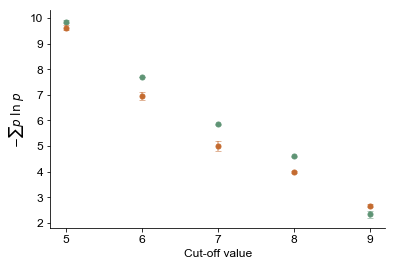

In [25]:
#Values reported here can be obtained from repeating above with different cutoffs
CUTOFF = [5, 6, 7, 8, 9]

AB=[9.617560234502246, 6.950407174041626, 5.017429299978249, 4.0009124637322175, 2.672601685671283]
AB_err =[0.10860657084838896, 0.1712382549851474, 0.19529572194118733, 0.047112190861580715, 0.0634477571283465]
G5=[9.85612194387157, 7.691561549662844, 5.845448287138363, 4.605220807835854, 2.338324291230559]
G5_err=[0.05141631406536792, 0.013267409216851926, 0.01499691510067676, 0.02327362654231207, 0.13678964909415373]

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.errorbar(CUTOFF, AB, yerr=AB_err, fmt="o", ms=5, color=c_AB, ecolor=e_AB, capsize=3, ls='none', barsabove=True)
ax.errorbar(CUTOFF, G5, yerr=G5_err, fmt="o", ms=5, color=c_G5, ecolor=e_G5, capsize=3, ls='none', barsabove=True)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax.xaxis.set_ticks(np.arange(5, 10, 1))
ax.set_ylabel("$- \sum p \  \ln \  p$")
ax.set_xlabel("Cut-off value");
#plt.savefig('entropy_cutoff.eps', format='eps', dpi=1000, transparent=True)

In [26]:
#Some of the plots shown in the manuscript were generated based on data using a 8.5 kJ/mol cutoff.
#Import list of clusters for trajectory 
traj = pd.read_csv('gromos_clustering/gromos/CUT_8.5/trajectory.dat', delim_whitespace=True, header=None)
traj = traj[1].values
n = 780 #number of clusters in log.dat file (remember 0)

#First, get the values calculated over the entire analysed trajectories 
traj_sort_cut = traj[indices.argsort()]
    
#Count cluster populations in AB alone and AB + 10074-G5
#AB alone
cluster_pop_AB_cut = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut, traj_sort_cut[:35000], 1/35000)

#AB + 10074-G5
cluster_pop_G5_cut = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut, traj_sort_cut[-35000:], 1/35000)

#Repeat above for first and second halves of AB alone
cluster_pop_AB_cut_0 = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut_0, traj_sort_cut[top_framesAB_0], 1/len(top_framesAB_0))

cluster_pop_AB_cut_1 = np.zeros((n, 1))
np.add.at(cluster_pop_AB_cut_1, traj_sort_cut[top_framesAB_1], 1/len(top_framesAB_1))
    
#Repeat above for first and second halves of AB + 10074-G5
cluster_pop_G5_cut_0 = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut_0, traj_sort_cut[np.asarray(top_framesG5_0)+35000], 1/len(top_framesG5_0))

cluster_pop_G5_cut_1 = np.zeros((n, 1))
np.add.at(cluster_pop_G5_cut_1, traj_sort_cut[np.asarray(top_framesG5_1)+35000], 1/len(top_framesG5_1))
       
AB_err = np.zeros((n))   
G5_err = np.zeros((n))  

for i in range(0, n):
    AB_err[i] = weighted_avg_and_std([cluster_pop_AB_cut_0[i][0], cluster_pop_AB_cut_1[i][0]], [sum_wAB_0, sum_wAB_1])[1]  
    G5_err[i] = weighted_avg_and_std([cluster_pop_G5_cut_0[i][0], cluster_pop_G5_cut_1[i][0]], [sum_wG5_0, sum_wG5_1])[1]

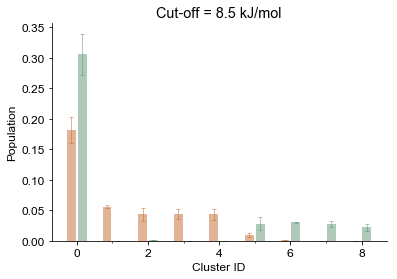

In [27]:
#To demonstrate convergence, plot the populationsof top five clusters for AB alone and AB + 10074-G5 with error bars from first and second halves of the simulations
#Select top five clusters for AB alone and AB + 10074-G5
clus= [0, 1, 2, 3, 4, 8, 14, 15, 19]

#Plot clusters with populations and errors
fig = plt.figure()
ax = plt.subplot(111)
x=np.arange(0, 9, 1)
ax.bar(x-0.15, cluster_pop_AB_cut[clus].flatten(), yerr=np.asarray(AB_err)[clus], ecolor=e_AB, color=c_AB, alpha=0.5, align='center', width=0.25, error_kw=dict(lw=1, capsize=2, capthick=1))
ax.bar(x+0.15, cluster_pop_G5_cut[clus].flatten(), yerr=np.asarray(G5_err)[clus], ecolor=e_G5, color=c_G5, alpha=0.5, align='center', width=0.25, error_kw=dict(lw=1, capsize=2, capthick=1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.arange(0, 9, 1), clus)
ax.set_ylabel("Population")
ax.set_xlabel("Cluster ID")
ax.set_title("Cut-off = 8.5 kJ/mol");
#plt.savefig('barpops.pdf', format='pdf', dpi=1000, transparent=True)

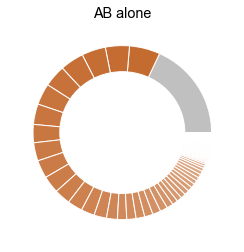

In [28]:
#To visualise the number of clusters and corresponding populations, make a "ring plot" for AB alone
#Execute twice to get size correct

#Create a circle for the center of the plot
my_circle=plt.Circle( (0, 0), 0.7, color='white')
AB_pops = cluster_pop_AB_cut.flatten()
size=np.sort(AB_pops)[::-1]

#Start first color as silver for shared cluster (Cluster ID:0)
color_list = ['silver']

#Then add more colors making them gradually get lighter
for i in range(0, len(size)):
    color_list.append(cmap_AB_ring(i/(80)))

#Plot
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.pie(size, colors=color_list, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })
ax.add_artist(my_circle)
ax.set_title("AB alone");
#plt.savefig('ring_AB.eps', format='eps', dpi=1000, transparent=True)

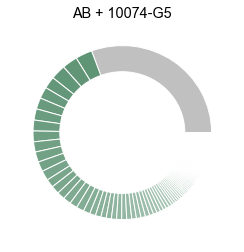

In [29]:
#To visualise the number of clusters and corresponding populations, make a "ring plot" for AB + 10074-G5
#Execute twice to get size correct

#Create a circle for the center of the plot
my_circle=plt.Circle( (0, 0), 0.7, color='white')
G5_pops = cluster_pop_G5_cut.flatten()
size=np.sort(G5_pops)[::-1]

#Start first color as silver for shared cluster (Cluster ID:0)
color_list = ['silver']

#Then add more colors making them gradually get lighter
for i in range(0, len(size)):
    color_list.append(cmap_G5_ring(i/(80)))
    
#Plot
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.pie(size, colors=color_list, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })
ax.add_artist(my_circle)
ax.set_title("AB + 10074-G5");

#plt.savefig('ring_G5.eps', format='eps', dpi=1000, transparent=True)

Now, we want to generate representative PDB files for the top five clusters in each simulation. To do this, we will select conformations in a weighted way, based on their proximity to the cluster center. Trajectories containing only 'topframes' were generated using `slice` in `mdtraj`. Note the periodic boundary conditions have been corrected in these trajectories. Conformations were aligned using `MatchMaker` in `Chimera`. Residue groups (hydrophobic, hydrophilic, charged, and polar) were selected using defaults in `Chimera`.

In [30]:
#Load in trajectories of top frames with corrected periodic boundary conditions
tAB_pbc = md.load('Zenodo/tAB_cut_withpbc.trr', top='Zenodo/template_AB.pdb')
tG5_pbc = md.load('Zenodo/tG5_cut_withpbc.trr', top='Zenodo/template_G5.pdb')

#Break up traj (with cluster IDs from above) into AB and G5
sort_clusAB = traj_sort_cut[:35000] 
sort_clusG5 = traj_sort_cut[35000:]

#Load in cluster centers, then assign each frame to 1 cluster
log = pd.read_csv('gromos_clustering/gromos/CUT_8.5/log.dat', delim_whitespace=True, header=None)
log_centers = log[5].values   #get list of cluster ID's in shuffled order

#Get true cluster centers
clus_center_sort_cut = indices.argsort()[log_centers]

#Get LJ contact maps for cluster centers
clus_center_LJ = LJall_AB_G5_cut[clus_center_sort_cut] 

In [31]:
#FOR AB alone
#Set cluster id
c=4 # The ones used in the manuscript are IDs = [0, 1, 2, 3, 4]

#Calculate root-mean-square deviation (RMSD) between each frame and cluster center
rmsd_list = np.sqrt(((LJ_AB_cut - clus_center_LJ[c]) ** 2).mean(axis=1))
    
#Generate weights based on RMSD. The smaller the RMSD, the more likely the frame will included.     
rmsd_weights = np.zeros_like(rmsd_list)
for i in range(0, len(rmsd_list)):
    if sort_clusAB[i] == c:
        if rmsd_list[i]==0:
            weight = 10000000 #set this weight very high as we want to be sure that the cluster center is included
        else:
            weight = 1/rmsd_list[i]
    else:
        weight = 0
    rmsd_weights[i] = weight

rmsd_weights /= rmsd_weights.sum()

#Pick structures randomly based on weights
structs = np.random.choice(range(0, 35000), 10, p = rmsd_weights, replace=False)

clus_AB = tAB_pbc.slice(structs)
clus_AB.save_pdb('gromos_clustering/gromos/CUT_8.5/pdb_files/cluster_{0}_AB.pdb'.format(c))

In [32]:
#SET CLUSTER ID
c=19 # The ones used in the manuscript are IDs = [0, 8, 14, 15, 19]

#FOR AB + 10074-G5
#Calculate root-mean-square deviation (RMSD) between each frame and cluster center
rmsd_list = np.sqrt(((LJ_G5_cut - clus_center_LJ[c]) ** 2).mean(axis=1))
    
#Generate weights based on RMSD. The smaller the RMSD, the more likely the frame will included.     
rmsd_weights = np.zeros_like(rmsd_list)

for i in range(0, len(rmsd_list)):
    if sort_clusG5[i] == c:
        if rmsd_list[i]==0:
            weight = 10000000 #set this weight very high as we want to be sure that the cluster center is included
        else:
            weight = 1/rmsd_list[i]
        rmsd_weights[i] = weight
        
rmsd_weights /= rmsd_weights.sum()

#Pick structures randomly based on weights
structs = np.random.choice(range(0, 35000), 10, p = rmsd_weights, replace=False)

clus_G5 = tG5_pbc.slice(structs)
clus_G5.save_pdb('gromos_clustering/gromos/CUT_8.5/pdb_files/cluster_{0}_G5.pdb'.format(c))

## Estimating entropy using 2D Ramachandran maps

In [33]:
#Calculate phi values for each trajectory
_, phi_AB = md.compute_phi(tAB, periodic=False)
_, phi_G5 = md.compute_phi(tG5, periodic=False)

#Calculate psi values for each trajectory
_, psi_AB = md.compute_psi(tAB, periodic=False)
_, psi_G5 = md.compute_psi(tG5, periodic=False)

#Calculate histograms on entire trajectories
AB_rama_ent = np.zeros((40))
G5_rama_ent = np.zeros((40))
diff_rama_ent = np.zeros((40))
bins=[np.linspace(-np.pi, np.pi, num=100), np.linspace(-np.pi, np.pi, num=100)]
for i in range (0, 40):
    counts, xedges, yedges = np.histogram2d(phi_AB[:, i], psi_AB[:, i+1], weights=wAB_eq, bins=bins, density=True)
    data = counts.flatten()
    ent_AB = -(data*np.ma.log(np.abs(data))).sum()
    AB_rama_ent[i] = ent_AB
    
    countsg5, xedges, yedges = np.histogram2d(phi_G5[:, i], psi_G5[:, i+1], weights=wG5_bound_eq, bins=bins, density=True)
    datag5 = countsg5.flatten()
    ent_G5 = -(datag5*np.ma.log(np.abs(datag5))).sum()
    G5_rama_ent[i] = ent_G5
    diff_rama_ent[i] = ent_G5-ent_AB
    
#Get errors 
#Phi for AB alone 
phi_AB_reps = np.reshape(phi_AB, (n_reps, np.int(len(wAB_eq)/n_reps), -1))
phi_AB_0 = phi_AB_reps.copy()[:, start_AB:mid_AB]                          
phi_AB_1 = phi_AB_reps.copy()[:, mid_AB:end_AB]                          
         
#Psi for AB alone
psi_AB_reps = np.reshape(psi_AB, (n_reps, np.int(len(wAB_eq)/n_reps), -1))
psi_AB_0 = psi_AB_reps.copy()[:, start_AB:mid_AB]                          
psi_AB_1 = psi_AB_reps.copy()[:, mid_AB:end_AB]   

#Phi for AB + 10074-G5
phi_G5_reps = np.reshape(phi_G5, (n_reps, np.int(len(wG5_bound_eq)/n_reps), -1))
phi_G5_0 = phi_G5_reps.copy()[:, start_G5:mid_G5]                          
phi_G5_1 = phi_G5_reps.copy()[:, mid_G5:end_G5]                          
                         
#Psi for AB + 10074-G5
psi_G5_reps = np.reshape(psi_G5, (n_reps, np.int(len(wG5_bound_eq)/n_reps), -1))
psi_G5_0 = psi_G5_reps.copy()[:, start_G5:mid_G5]                          
psi_G5_1 = psi_G5_reps.copy()[:, mid_G5:end_G5]
                         
#Calculate histograms for each half    
AB_rama_ent_err = np.zeros((40))
G5_rama_ent_err = np.zeros((40))
for i in range (0, 40):
    #for AB alone
    counts0ab, xedges, yedges = np.histogram2d(np.reshape(phi_AB_0, (-1, 41))[:, i], np.reshape(psi_AB_0, (-1, 41))[:, i+1], weights=wAB_0.flatten(), bins=bins, density=True)
    data0ab = counts0ab.flatten()
    ent_AB0 = -(data0ab*np.ma.log(np.abs(data0ab))).sum()
    
    counts1ab, xedges, yedges = np.histogram2d(np.reshape(phi_AB_1, (-1, 41))[:, i], np.reshape(psi_AB_1, (-1, 41))[:, i+1], weights=wAB_1.flatten(), bins=bins, density=True)
    data1ab = counts1ab.flatten()
    ent_AB1 = -(data1ab*np.ma.log(np.abs(data1ab))).sum()

    AB_rama_ent_err[i] = weighted_avg_and_std([ent_AB0, ent_AB1], [sum_wAB_0, sum_wAB_1])[1]
    
    #for AB + 10074-G5
    counts0g5, xedges, yedges = np.histogram2d(np.reshape(phi_G5_0, (-1, 41))[:, i], np.reshape(psi_G5_0, (-1, 41))[:, i+1], weights=wG5_0.flatten(), bins=bins, density=True)
    data0g5 = counts0g5.flatten()
    ent_G50 = -(data0g5*np.ma.log(np.abs(data0g5))).sum()
    
    counts1g5, xedges, yedges = np.histogram2d(np.reshape(phi_G5_1, (-1, 41))[:, i], np.reshape(psi_G5_1, (-1, 41))[:, i+1], weights=wG5_1.flatten(), bins=bins, density=True)
    data1g5 = counts1g5.flatten()
    ent_G51 = -(data1g5*np.ma.log(np.abs(data1g5))).sum()

    G5_rama_ent_err[i] = weighted_avg_and_std([ent_G50, ent_G51], [sum_wG5_0, sum_wG5_1])[1]


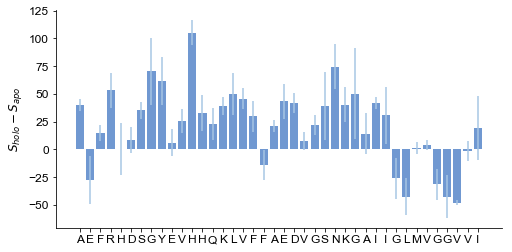

In [34]:
#Plot Ramachandran entropy per residue
labels = np.arange(0, 40)
Y = np.asarray(diff_rama_ent)

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 4))
rects = ax.bar(x, Y, width, yerr=np.sqrt(np.asarray(AB_rama_ent_err)**2+np.asarray(G5_rama_ent_err)**2), color=blue_dark, ecolor=blue_light)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$S_{holo}-S_{apo}$')
ax.set_xticks(x)
ax.xaxis.tick_bottom()
ax.set_xticklabels(list(ab_seq_no_ter))

ax.legend()
ax.tick_params(labeltop=False)
ax.tick_params(labelbottom=True)
ax.xaxis.set_label_position('top')

#fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=False);
#plt.savefig('rama_entro_normalised.eps', format='eps', dpi=5000, transparent=True)


## Radii of gyration
We will calculate and plot the radius of gyration using two different sets of trajectories. First, we will plot the distributions calculated on the entire trajectories (all frames). We will also calculate it on the topframes subset.

In [35]:
#First, calculate the distributions of the radii of gyration calculated on the entire analysed trajectories. 

#Calculate radius of gyration on entire trajectory for AB alone
masses = np.array([a.element.mass for a in tAB.top.atoms])
gyrm_AB = md.compute_rg(tAB, masses=masses)

#Then divide up gyrm_AB into two halves for convergence analysis
gyrm_AB_reps = np.reshape(gyrm_AB, (n_reps, np.int(len(wAB_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
gyrm_AB_0 = gyrm_AB_reps.copy()[:, start_AB:mid_AB]
gyrm_AB_1 = gyrm_AB_reps.copy()[:, mid_AB:end_AB]

err_gyrm_AB = weighted_avg_and_std([(gyrm_AB_0*wAB_0).sum(), (gyrm_AB_1*wAB_1).sum()], [sum_wAB_0, sum_wAB_1])[1]
           
#Calculate radius of gyration on entire trajectory for AB + 10074-G5
#First get trajectory that is only protein
tG5_prot = tG5.topology.select('protein')
tG5_protein = tG5.atom_slice(tG5_prot, inplace=False)

masses = np.array([a.element.mass for a in tG5_protein.top.atoms])
gyrm_G5 = md.compute_rg(tG5_protein, masses=masses)

#Then divide up gyrm_G5 into two halves for convergence analysis
gyrm_G5_reps = np.reshape(gyrm_G5, (n_reps, np.int(len(wG5_bound_eq)/n_reps), 1))
gyrm_G5_0 = gyrm_G5_reps.copy()[:, start_G5:mid_G5]
gyrm_G5_1 = gyrm_G5_reps.copy()[:, mid_G5:end_G5]

err_gyrm_G5 = weighted_avg_and_std([(gyrm_G5_0*wG5_0).sum(), (gyrm_G5_1*wG5_1).sum()], [sum_wG5_0, sum_wG5_1])[1]

print('The average radius of gyration for AB alone', (gyrm_AB*wAB_eq).sum(), '+/-', err_gyrm_AB)    
print('The average radius of gyration for AB + 10074-G5 is', (gyrm_G5*wG5_bound_eq).sum(), '+/-', err_gyrm_G5)    

The average radius of gyration for AB alone 1.1456065087469423 +/- 0.0019180271419171275
The average radius of gyration for AB + 10074-G5 is 1.1159652738157009 +/- 0.004365177432770133


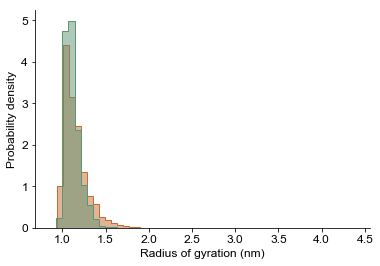

In [36]:
#Plot histogram of radius of gyration from full analysed trajectories 
ax = plt.subplot(111)

ax.hist(gyrm_AB, histtype='stepfilled', color=e_AB, weights=wAB_eq, bins=50, density=True)
ax.hist(gyrm_AB, histtype='step',       color=c_AB, weights=wAB_eq, bins=50, density=True)

ax.hist(gyrm_G5, histtype='stepfilled', color=e_G5, weights=wG5_bound_eq, bins=50, density=True)
ax.hist(gyrm_G5, histtype='step',       color=c_G5, weights=wG5_bound_eq, bins=50, density=True)

ax.set_xlabel("Radius of gyration (nm)")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
#plt.savefig('rgyr_normed.pdf', format='pdf', dpi=1000, transparent=True)

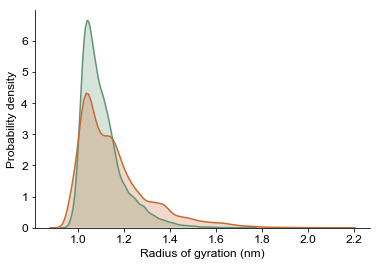

In [37]:
#Now we can do the same for top frames using kernel density estimates to reprsent the data
ax = plt.subplot(111)
#Recalculate rgyr on topframes for AB alone
masses = np.array([a.element.mass for a in tAB_pbc.top.atoms])
gyrm_AB_top = md.compute_rg(tAB_pbc, masses=masses)

#Recalculate rgyr on topframes for AB + 10074-G5
masses = np.array([a.element.mass for a in tG5_pbc.top.atoms])
gyrm_G5_top = md.compute_rg(tG5_pbc, masses=masses)

sns.kdeplot(gyrm_G5_top, shade=True, color=c_G5)
sns.kdeplot(gyrm_AB_top, shade=True, color=c_AB)
ax.set_xlabel("Radius of gyration (nm)")
ax.set_ylabel("Probability density")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
#plt.savefig('kde_rgyr.pdf', format='pdf', dpi=1000, transparent=True)

## Solvent accessible surface area analysis

Hydrophobic surface areas were computed using the `GROMACS gmx sasa` tool using `-surface 'group 1' -output '"Hydrophobic" group 1 and charge {-0.2 to 0.2}; "Hydrophilic" group 1 and not charge {-0.2 to 0.2}; "Total" group 1'`

The holo ensemble was calculated only on the protein surface, but accounts for the presence of the compound. All input files for this calculation can be found in `\sasa`. 

In [38]:
#Import output from gmx energy 
sasaAB = pd.read_csv('Zenodo/sasa_AB_alone_area.xvg', sep="\s+", engine="python", skiprows=153, header=None)
sasaAB_mat = sasaAB.values

sasaG5_d_n = pd.read_csv('Zenodo/sasa_AB_with_10074_G5_area.xvg', sep="\s+", engine="python", skiprows=156, header=None)
sasaG5_d_n_mat = sasaG5_d_n.values

#Useful indices 
phobic_all_ind = [2]
philic_all_ind = [3]
total_all_ind  = [4]
phobic_res_ind = [5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,110,113,116,119,122,125,128]
philic_res_ind = [6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,84,87,90,93,96,99,102,105,108,111,114,117,120,123,126,129]
total_res_ind  = [7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,73,76,79,82,85,88,91,94,97,100,103,106,109,112,115,118,121,124,127,130]

#Get hydrophobic, hydrophilic, total, and residue-specific values    
sasaAB_dict = {'phobicAB_all': sasaAB_mat[:, phobic_all_ind], 'philicAB_all': sasaAB_mat[:, philic_all_ind], 'totalAB_all': sasaAB_mat[:, total_all_ind], 
               'phobicAB_res_all': sasaAB_mat[:, phobic_res_ind], 'philicAB_res_all': sasaAB_mat[:, philic_res_ind], 'totalAB_res_all' : sasaAB_mat[:, total_res_ind]}
                 
sasaG5_dict = {'phobicG5_d_n_all': sasaG5_d_n_mat[:, phobic_all_ind], 'philicG5_d_n_all': sasaG5_d_n_mat[:, philic_all_ind], 'totalG5_d_n_all': sasaG5_d_n_mat[:, total_all_ind], 
               'phobicG5_res_d_n_all': sasaG5_d_n_mat[:, phobic_res_ind], 'philicG5_res_d_n_all': sasaG5_d_n_mat[:, philic_res_ind], 'totalG5_res_d_n_all': sasaG5_d_n_mat[:, total_res_ind]}
    
#Get topframes versions
sasaAB_mat_cut = sasaAB_mat[top_framesAB]
sasaG5_d_n_mat_cut = sasaG5_d_n_mat[top_framesG5]
    
#Get hydrophobic, hydrophilic, total, and residue-specific values
sasaAB_cut_dict = {'phobicAB': sasaAB_mat_cut[:, phobic_all_ind], 'philicAB': sasaAB_mat_cut[:, philic_all_ind], 'totalAB': sasaAB_mat_cut[:, total_all_ind], 
                   'phobicAB_res': sasaAB_mat_cut[:, phobic_res_ind], 'philicAB_res': sasaAB_mat_cut[:, philic_res_ind], 'totalAB_res': sasaAB_mat_cut[:, total_res_ind]}
           
sasaG5_cut_dict = {'phobicG5_d_n': sasaG5_d_n_mat_cut[:, phobic_all_ind], 'philicG5_d_n': sasaG5_d_n_mat_cut[:, philic_all_ind], 'totalG5_d_n': sasaG5_d_n_mat_cut[:, total_all_ind], 
                   'phobicG5_res_d_n': sasaG5_d_n_mat_cut[:, phobic_res_ind], 'philicG5_res_d_n': sasaG5_d_n_mat_cut[:, philic_res_ind], 'totalG5_res_d_n': sasaG5_d_n_mat_cut[:, total_res_ind]}

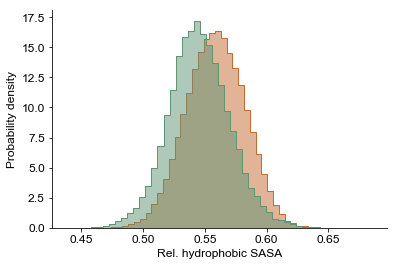

In [39]:
#Plot histogram of relative hydrophobic SASA  from full analysed trajectories 
ax = plt.subplot(111)

ax.hist(sasaAB_dict['phobicAB_all']/sasaAB_dict['totalAB_all'], histtype='stepfilled', color=e_AB, weights=wAB_eq, bins=50, density=True)
ax.hist(sasaAB_dict['phobicAB_all']/sasaAB_dict['totalAB_all'], histtype='step',       color=c_AB, weights=wAB_eq, bins=50, density=True)

ax.hist(sasaG5_dict['phobicG5_d_n_all']/sasaG5_dict['totalG5_d_n_all'], histtype='stepfilled', color=e_G5, weights=wG5_bound_eq, bins=50, density=True)
ax.hist(sasaG5_dict['phobicG5_d_n_all']/sasaG5_dict['totalG5_d_n_all'], histtype='step',       color=c_G5, weights=wG5_bound_eq, bins=50, density=True)

ax.set_xlabel("Rel. hydrophobic SASA")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
#plt.savefig('rel_SASA_full.pdf', format='pdf', dpi=1000, transparent=True)

In [40]:
#Now, we want to determine each of the values for the clusters from the 8.5 kJ/mol cutoff above
c = [0, 1, 2, 3, 4]
AB_clus_sasa_vals = np.zeros(len(c))
for iteration, j in enumerate(c):
    val = []
    for i in range(0,len(sort_clusAB)):
        if sort_clusAB[i] == j:
            val.append(sasaAB_cut_dict['phobicAB'][i]/sasaAB_cut_dict['totalAB'][i])
    AB_clus_sasa_vals[iteration] = np.asarray(val).mean()

        
c = [0, 8, 14, 15, 19]
G5_clus_sasa_vals = np.zeros(len(c))
for iteration, j in enumerate(c):
    val = []
    for i in range(0, len(sort_clusG5)):
        if sort_clusG5[i] == j:
            val.append(sasaG5_cut_dict['phobicG5_d_n'][i]/sasaG5_cut_dict['totalG5_d_n'][i])
    G5_clus_sasa_vals[iteration] = np.asarray(val).mean()

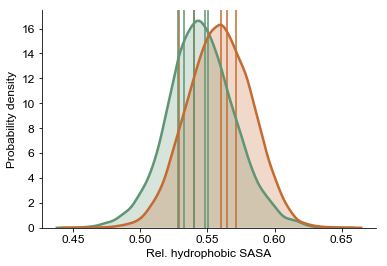

In [41]:
#Plot kernel density estimate with lines indicating locations of each cluster
#Plot lines for each cluster
ax = plt.subplot(111)
for j in range(0, 5):
    plt.axvline(x=AB_clus_sasa_vals[j], color=c_AB)

for j in range(0, 5):
    plt.axvline(x=G5_clus_sasa_vals[j], color=c_G5)

#Plot kernel density plot
sns.kdeplot(sasaG5_cut_dict['phobicG5_d_n'].flatten()/sasaG5_cut_dict['totalG5_d_n'].flatten(), shade=True, color=c_G5, lw=2.5)
sns.kdeplot(sasaAB_cut_dict['phobicAB'].flatten()/sasaAB_cut_dict['totalAB'].flatten(), shade=True, color=c_AB, lw=2.5)

ax.set_xlabel("Rel. hydrophobic SASA")
ax.set_ylabel("Probability density")

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
#plt.savefig('kde_hydro_sasa_lines.pdf', format='pdf', dpi=1000, transparent=True)

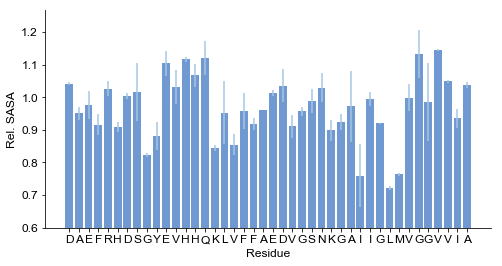

In [42]:
#Plot the ratio of relative (total) solvent accessible surface areas per residue (bound)/(unbound)
#Calculate standard deviations between first and second halves:

#First get AB alone into two halves by splitting array per replica
sasa_AB_reps = np.reshape(sasaAB_mat, (n_reps, np.int(len(wAB_eq)/n_reps), -1))
sasa_AB_0 = sasa_AB_reps.copy()[:, start_AB:mid_AB]
sasa_AB_1 = sasa_AB_reps.copy()[:, mid_AB:end_AB]

sasaAB_reps_0 = {'phobicAB_0': sasa_AB_0[:, :, phobic_all_ind], 'philicAB_0': sasa_AB_0[:, :, philic_all_ind], 'totalAB_0': sasa_AB_0[:, :, total_all_ind],
                 'phobicAB_0_res': sasa_AB_0[:, :, phobic_res_ind], 'philicAB_0_res': sasa_AB_0[:, :, philic_res_ind], 'totalAB_0_res': sasa_AB_0[:, :, total_res_ind]}
sasaAB_reps_1 = {'phobicAB_1': sasa_AB_1[:, :, phobic_all_ind], 'philicAB_1': sasa_AB_1[:, :, philic_all_ind], 'totalAB_1': sasa_AB_1[:, :, 4],
                 'phobicAB_1_res': sasa_AB_1[:, :, phobic_res_ind], 'philicAB_1_res': sasa_AB_1[:, :, philic_res_ind], 'totalAB_1_res': sasa_AB_1[:, :, total_res_ind]}

#Get AB + 10074-G5 into two halves
sasa_G5_reps = np.reshape(sasaG5_d_n_mat, (n_reps, np.int(len(wG5_bound_eq)/n_reps), -1))
sasa_G5_0 = sasa_G5_reps.copy()[:, start_G5:mid_G5]
sasa_G5_1 = sasa_G5_reps.copy()[:, mid_G5:end_G5]

sasaG5_reps_0 = {'phobicG5_0': sasa_G5_0[:, :, phobic_all_ind], 'philicG5_0': sasa_G5_0[:, :, philic_all_ind], 'totalG5_0': sasa_G5_0[:, :, total_all_ind],
                 'phobicG5_0_res': sasa_G5_0[:, :, phobic_res_ind], 'philicG5_0_res': sasa_G5_0[:, :, philic_res_ind], 'totalG5_0_res': sasa_G5_0[:, :, total_res_ind]}

sasaG5_reps_1 = {'phobicG5_1': sasa_G5_1[:, :, phobic_all_ind], 'philicG5_1': sasa_G5_1[:, :, philic_all_ind], 'totalG5_1': sasa_G5_1[:, :, total_all_ind],
                 'phobicG5_1_res': sasa_G5_1[:, :, phobic_res_ind], 'philicG5_1_res': sasa_G5_1[:, :, philic_res_ind], 'totalG5_1_res': sasa_G5_1[:, :, total_res_ind]}
    
#Get errors for AB alone
res = np.arange(1, 43)
AB_alone_0 = np.zeros((42))
AB_alone_1 = np.zeros((42))

for i in range(0, 42):
    AB_alone_0[i] = (sasaAB_reps_0['totalAB_0_res'][:, :, i].flatten()*wAB_0.flatten()).sum()
    AB_alone_1[i] = (sasaAB_reps_1['totalAB_1_res'][:, :, i].flatten()*wAB_1.flatten()).sum()

#Get errors for AB+10074-G5
G5_alone_0 = np.zeros((42))
G5_alone_1 = np.zeros((42))

for i in range(0, 42):
    G5_alone_0[i] = (sasaG5_reps_0['totalG5_0_res'][:, :, i].flatten()*wG5_0.flatten()).sum()
    G5_alone_1[i] = (sasaG5_reps_1['totalG5_1_res'][:, :, i].flatten()*wG5_1.flatten()).sum()

#Plot changes in SASA per residue
fig, ax = plt.subplots(figsize=(8, 4))
ratio = np.zeros((42))
for i in range(0, 42):
    ratio[i]= (sasaG5_dict['totalG5_res_d_n_all'][:, i].flatten()*wG5_bound_eq).sum()/(sasaAB_dict['totalAB_res_all'][:, i].flatten()*wAB_eq).sum()

ax.bar(res, ratio, color=blue_dark, ecolor=blue_light, yerr=np.std([(G5_alone_0/AB_alone_0), (G5_alone_1/AB_alone_1)], axis=0))
ax.set_xticks(res)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rel. SASA')
ax.set_xlabel('Residue')
ax.xaxis.tick_bottom()
ax.set_xticklabels(list(ab_seq))
ax.legend()
ax.tick_params(labeltop=False)
ax.tick_params(labelbottom=True)
ax.xaxis.set_label_position('bottom')
ax.set_ylim(bottom=0.6)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#plt.savefig('SASA_per_res.eps', format='eps', dpi=1000, transparent=True)

## Characterisation of water properties

Water properties were calculated using `GROMACS gmx_mpi hbond`. For full code, see `water_shell/AB_alone/run_hbond_parallel.sh`, `water_shell/AB_with_10074_G5/HBOND_G5_AND_AB/run_hbond_parallel.sh`, and `water_shell/AB_with_10074_G5/HBOND_G5_DISSOCIATED/run_hbond_parallel.sh`.

Average number of hydrogen (H) bonds per water molecule in the shell (all water molecules within 0.4 nm of Aβ42 with and without 10074-G5). Distributions are shown using kernel density estimates of 35,000 points each sampled based on metadynamics weights using a Gaussian kernel. The orange curve represents the apo ensemble, the green curve represents the holo ensemble. (b) Average number of H bonds per water molecule in the bulk (all water molecules not in the shell) using the same parameters and colors as shown in panel (a). (c) Kernel density estimates of the number of water molecule in the shell for the apo (orange curve, solid line) and holo (green curve, solid line) simulations. Using the dissociated frames from the holo simulation (in which 10074-G5 was further than 0.8 nm from the protein), we estimate the number of water molecules in the shell of 10074-G5 alone to be approximately 44.2. The orange dashed distribution represents the apo simulation shifted by this value. 

In [43]:
#Import output from hbond analysis
#FORMAT: frame, shellhbonds, shelltotat, bulkhbonds, bulktotat. See run_hbond_parallel.sh files for definitions.
#Import AB alone
HB_AB = np.loadtxt('water_shell/AB_alone/hbond_output.out')

#Import AB + 10074-G5
HB_G5 = np.loadtxt('water_shell/AB_with_10074_G5/HBOND_G5_AND_AB/hbond_output.out')

#Import 10074-G5 in dissociated state
HB_G5_alone = np.loadtxt('water_shell/AB_with_10074_G5/HBOND_G5_DISSOCIATED/hbond_output_drug.out')

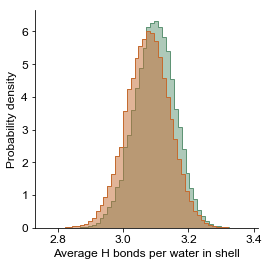

In [44]:
#Determine average number of H bonds per water in shell
shell_av_AB = HB_AB[:, 1]/(HB_AB[:, 2]/3)
shell_av_G5 = HB_G5[:, 1]/(HB_G5[:, 2]/3)

#Plot histograms
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(111)

ax.hist(shell_av_G5, weights=wG5_bound_eq, bins=50, color=c_G5, density=True, histtype='step')
ax.hist(shell_av_G5, weights=wG5_bound_eq, bins=50, color=e_G5, density=True, histtype='stepfilled')
ax.hist(shell_av_AB, weights=wAB_eq, bins=50, color=c_AB, density=True, histtype='step')
ax.hist(shell_av_AB, weights=wAB_eq, bins=50, color=e_AB, density=True, histtype='stepfilled')
ax.set_xlabel("Average H bonds per water in shell")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False);

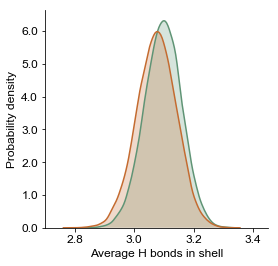

In [45]:
#repeat the analysis above using kernel density estimation of top frames
shell_av_AB_cut = shell_av_AB[top_framesAB]
shell_av_G5_cut = shell_av_G5[top_framesG5]

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(111)

sns.kdeplot(shell_av_G5_cut, shade=True, color=c_G5)
sns.kdeplot(shell_av_AB_cut, shade=True, color=c_AB)

ax.set_xlabel("Average H bonds in shell")
ax.set_ylabel("Probability density")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.set_xlim([2.7, 3.45]);
#plt.savefig('kde_av_h_bonds.pdf', format='pdf', dpi=1000, transparent=True)

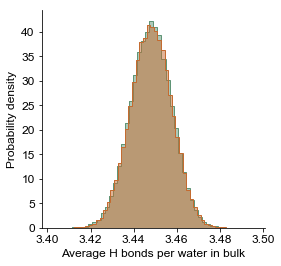

In [46]:
#Determine average number of H bonds per water in bulk
bulk_av_AB = HB_AB[:, 3]/(HB_AB[:, 4]/3)
bulk_av_G5 = HB_G5[:, 3]/(HB_G5[:, 4]/3)

#Plot histograms
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(111)

ax.hist(bulk_av_G5, weights=wG5_bound_eq, bins=50, color=c_G5, density=True, histtype='step')
ax.hist(bulk_av_G5, weights=wG5_bound_eq, bins=50, color=e_G5, density=True, histtype='stepfilled')
ax.hist(bulk_av_AB, weights=wAB_eq, bins=50, color=c_AB, density=True, histtype='step')
ax.hist(bulk_av_AB, weights=wAB_eq, bins=50, color=e_AB, density=True, histtype='stepfilled')
ax.set_xlabel("Average H bonds per water in bulk")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False);

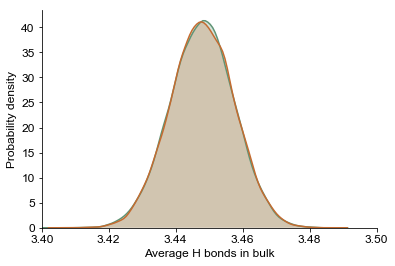

In [47]:
#Repeat the analysis above using kernel density estimation of top frames
bulk_av_AB_cut = bulk_av_AB[top_framesAB]   
bulk_av_G5_cut = bulk_av_G5[top_framesG5]

ax = plt.subplot(111)

sns.kdeplot(bulk_av_G5_cut, shade=True, color=c_G5)
sns.kdeplot(bulk_av_AB_cut, shade=True, color=c_AB)

ax.set_xlabel("Average H bonds in bulk")
ax.set_ylabel("Probability density")

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.set_xlim([3.4, 3.50]);
#plt.savefig('kde_av_h_bonds_BULK.pdf', format='pdf', dpi=1000, transparent=True)

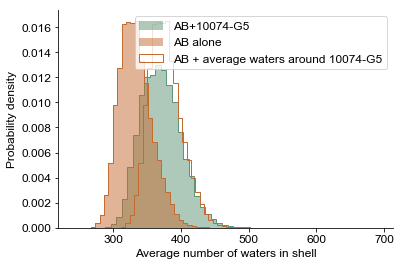

In [48]:
#Determine number of waters in the shell 

#First, determine number of atoms in the shell
#For AB alone
shell_atoms_AB = HB_AB[:, 2]
#For AB alone + 10074-G5
shell_atoms_G5 = HB_G5[:, 2]
#For 10074-G5
shell_atoms_G5_alone = HB_G5_alone[:, 2]

#Fetermine average number of waters around 10074-G5
G5_waters = (shell_atoms_G5_alone*wG5_unbound).sum()/3

#Plot histograms
ax = plt.subplot(111)

ax.hist(shell_atoms_G5/3, weights=wG5_bound_eq, bins=50, color=c_G5, density=True, histtype='step')
ax.hist(shell_atoms_G5/3, weights=wG5_bound_eq, bins=50, color=e_G5, density=True, histtype='stepfilled', label='AB+10074-G5')
ax.hist(shell_atoms_AB/3, weights=wAB_eq, bins=50, color=c_AB, density=True, histtype='step')
ax.hist(shell_atoms_AB/3, weights=wAB_eq, bins=50, color=e_AB, density=True, histtype='stepfilled', label='AB alone')
ax.hist(shell_atoms_AB/3+G5_waters, weights=wAB_eq, bins=50, color=c_AB, density=True, histtype='step', label='AB + average waters around 10074-G5')

ax.set_xlabel("Average number of waters in shell")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.legend();

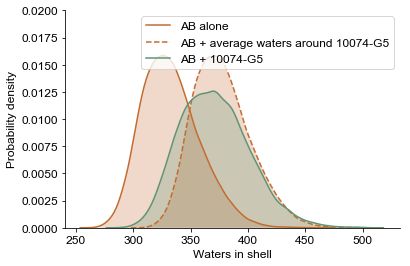

In [49]:
#Plot the above with using kernel density estimates
shell_atoms_AB_cut = shell_atoms_AB[top_framesAB]
shell_atoms_G5_cut = shell_atoms_G5[top_framesG5]

ax = plt.subplot(111)

sns.kdeplot(np.asarray(shell_atoms_AB_cut)/3, shade=True, color=c_AB, label='AB alone')
sns.kdeplot((np.asarray(shell_atoms_AB_cut)/3)+(shell_atoms_G5_alone*wG5_unbound).sum()/3, shade=True, color=c_AB, linestyle="--", label='AB + average waters around 10074-G5')
sns.kdeplot(np.asarray(shell_atoms_G5_cut)/3, shade=True, color=c_G5,label='AB + 10074-G5')

ax.set_xlabel("Waters in shell")
ax.set_ylabel("Probability density")

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0, .02]);
#plt.savefig('kde_number_shell.pdf', format='pdf', dpi=1000, transparent=True)

In [50]:
#Determine average values for hbonds in shell and in bulk with errors 
#Calculate errors from standard devations from first and second halves of analysed trajectories

#First split AB alone by replica
shell_av_AB_split = np.reshape(shell_av_AB.copy(), (n_reps, np.int(len(wAB_eq)/n_reps), 1))
bulk_av_AB_split = np.reshape(bulk_av_AB.copy(), (n_reps, np.int(len(wAB_eq)/n_reps), 1))

#Split observables into first and second halves by splitting array per replica
s_AB_0 = shell_av_AB_split.copy()[:, start_AB:mid_AB]
b_AB_0 = bulk_av_AB_split.copy()[:, start_AB:mid_AB]
s_AB_1 = shell_av_AB_split.copy()[:, mid_AB:end_AB]
b_AB_1 = bulk_av_AB_split.copy()[:, mid_AB:end_AB]

#Calculate error on bulk values 
err_AB_b = weighted_avg_and_std([(b_AB_0*wAB_0).sum(), (b_AB_1*wAB_1).sum()], [sum_wAB_0, sum_wAB_1])[1]

#Calculate error on shell values 
err_AB_s = weighted_avg_and_std([(s_AB_0*wAB_0).sum(), (s_AB_1*wAB_1).sum()], [sum_wAB_0, sum_wAB_1])[1]

#Split AB + 10074-G5 by  replica
shell_av_G5_split = np.reshape(shell_av_G5.copy(), (n_reps, np.int(len(wG5_bound_eq)/n_reps), 1))
bulk_av_G5_split = np.reshape(bulk_av_G5.copy(), (n_reps, np.int(len(wG5_bound_eq)/n_reps), 1))

#Split observables into first and second halves by splitting array per replica
s_G5_0 = shell_av_G5_split.copy()[:, start_G5:mid_G5]
b_G5_0 = bulk_av_G5_split.copy()[:, start_G5:mid_G5]
s_G5_1 = shell_av_G5_split.copy()[:, mid_G5:end_G5]
b_G5_1 = bulk_av_G5_split.copy()[:, mid_G5:end_G5]

#Calculate error on shell values 
err_G5_s = weighted_avg_and_std([(s_G5_0*wG5_0).sum(), (s_G5_1*wG5_1).sum()], [sum_wG5_0, sum_wG5_1])[1]

#Calculate error on bulk values 
err_G5_b = weighted_avg_and_std([(b_G5_0*wG5_0).sum(), (b_G5_1*wG5_1).sum()], [sum_wG5_0, sum_wG5_1])[1]

print('The average number of waters in the shell for AB alone is', (shell_av_AB*wAB_eq).sum(), '+/-', err_AB_s)    
print('The average number of waters in the shell for AB + 10074-G5 is', (shell_av_G5*wG5_bound_eq).sum(), '+/-', err_G5_s)    

print('The average number of waters in the bulk for AB alone is', (bulk_av_AB*wAB_eq).sum(), '+/-', err_AB_b)    
print('The average number of waters in the bulk for AB + 10074-G5 is', (bulk_av_G5*wG5_bound_eq).sum(), '+/-', err_G5_b)    

The average number of waters in the shell for AB alone is 3.0750909473052923 +/- 3.8493502210692146e-05
The average number of waters in the shell for AB + 10074-G5 is 3.095864197009251 +/- 0.0004595471561543762
The average number of waters in the bulk for AB alone is 3.448012914897854 +/- 2.1365696668374315e-05
The average number of waters in the bulk for AB + 10074-G5 is 3.4479052876491734 +/- 2.382109703488707e-05


## Residue-specific interaction energies between AB and 10074-G5

Lennard Jones (LJ) and Coulombic interaction energies were calculated using `GROMACS gmx energy`.

In [51]:
#Load output data from gmx energy
Coul_drug = np.loadtxt('Zenodo/interaction_energies_Coul_SR.xvg', comments=('#', '@'))
LJ_drug = np.loadtxt('Zenodo/interaction_energies_LJ_SR.xvg', comments=('#', '@'))

In [52]:
#Calculate the Coul for AB and 10075-G5 for each frame:
#Triangulate output from gmx energy
tri_coul = np.empty((len(Coul_drug), 43, 43))
for i in range(0, len(Coul_drug)):
    data = Coul_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_coul[i] = out
    
#Apply weights
tri_coul_w = tri_coul * wG5_bound_eq.reshape((-1, 1, 1))
 
#Get average values    
Coul_means = tri_coul_w.sum(axis=0)[:, -1]

#Calculate the LJ for AB and 10075-G5 for each frame:   
#Triangulate output from gmx energy
tri_lj = np.empty((len(LJ_drug), 43, 43))
for i in range(0, len(LJ_drug)):
    data = LJ_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_lj[i] = out
    
#Apply weights    
tri_lj_w = tri_lj * wG5_bound_eq.reshape((-1, 1, 1))
    
#Get average values        
LJ_means = tri_lj_w.sum(axis=0)[:, -1]

In [53]:
#Get errorbars using standard deviations of first and second halves
LJ_means_split = np.reshape(LJ_drug.copy(), (n_reps, np.int(len(wG5_bound)/n_reps), -1))
Coul_means_split = np.reshape(Coul_drug.copy(), (n_reps, np.int(len(wG5_bound)/n_reps), -1))

G5_lj_0 = LJ_means_split.copy()[:, start_G5:mid_G5]
G5_ljs_1 = LJ_means_split.copy()[:, mid_G5:end_G5]
G5_coul_0 = Coul_means_split.copy()[:, start_G5:mid_G5]
G5_coul_1 = Coul_means_split.copy()[:, mid_G5:end_G5]
    
#Calculate the errors for LJ:s
#Triangulate output from gmx energy

tri_lj_0 = np.empty((wG5_0.flatten().shape[0], 43, 43))
for i in range(0, wG5_0.flatten().shape[0]):
    data = LJ_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_lj_0[i] = out
         
tri_lj_1 = np.empty((wG5_0.flatten().shape[0], 43, 43))
for i in range(0, wG5_0.flatten().shape[0]):
    data = LJ_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_lj_1[i] = out
    
#Apply weights
tri_lj_w_0 = tri_lj_0 * wG5_0.reshape((-1, 1, 1))
tri_lj_w_1 = tri_lj_1 * wG5_1.reshape((-1, 1, 1))
    
#Calculate errors    
errs_lj = np.empty((42))
for i in range(0, 42):
    errs_lj[i] = weighted_avg_and_std([tri_lj_w_0.sum(axis=0)[:, -1][i], tri_lj_w_1.sum(axis=0)[:, -1][i]], [sum_wG5_0, sum_wG5_1])[1]

#Calculate the errors for Coul:
#Triangulate output from gmx energy
tri_coul_0 = np.empty((wG5_0.flatten().shape[0], 43, 43))
for i in range(0, wG5_0.flatten().shape[0]):
    data = Coul_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_coul_0[i] = out
    
tri_coul_1 = np.empty((wG5_0.flatten().shape[0], 43, 43))
for i in range(0, wG5_0.flatten().shape[0]):
    data = Coul_drug[i, 1:947]
    out = np.zeros((43, 43))
    inds = np.triu_indices(len(out))
    out[inds] = data
    tri_coul_1[i] = out

#Apply weights 
tri_coul_w_0 = tri_coul_0 * wG5_0.reshape((-1, 1, 1))
tri_coul_w_1 = tri_coul_1 * wG5_1.reshape((-1, 1, 1))

#Calculate errors    
errs_coul = np.empty((42))
for i in range(0, 42):
    errs_coul[i] = weighted_avg_and_std([tri_coul_w_0.sum(axis=0)[:, -1][i], tri_coul_w_1.sum(axis=0)[:, -1][i]], [sum_wG5_0, sum_wG5_1])[1]

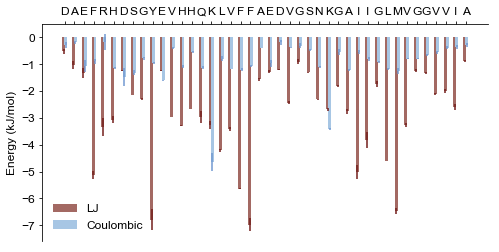

In [54]:
#Plot LJ and Coul per residue with error bars
labels = np.arange(1, 43)
LJ_means = LJ_means.copy()[0:42]
Coul_means = Coul_means.copy()[0:42]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/3, LJ_means, width, label='LJ', yerr=errs_lj, color=red_light, ecolor=red_dark)
rects2 = ax.bar(x + width/3, Coul_means, width, label='Coulombic', yerr=errs_coul, color=blue_light, ecolor=blue_dark)

#Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy (kJ/mol)')

ax.set_xticks(x)
ax.xaxis.tick_top()
ax.set_xticklabels(list(ab_seq))
ax.legend()
ax.tick_params(labeltop=True)
ax.tick_params(labelbottom=False)
ax.xaxis.set_label_position('top')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(frameon=False);
#plt.savefig('G5_LJ_Coul.eps', format='eps', dpi=1000, transparent=True)